# Import the Libraries¶

In [5]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [6]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



Read an Image


Now we will read a sample image using the function cv2.imread() and then display that image using the matplotlib library.

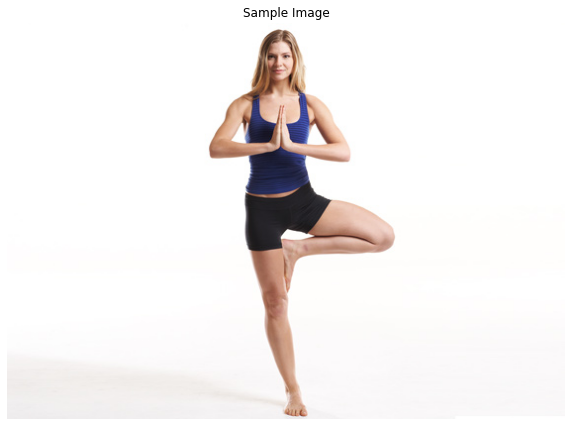

In [8]:
# Read an image from the specified path.
sample_img = cv2.imread('./DATASET/TRAIN/tree/File72.jpg')

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()


Perform Pose Detection¶

In [9]:
# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):
        
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.4881570637226105
y: 0.10121241211891174
z: -0.25872212648391724
visibility: 0.9999741315841675

LEFT_EYE_INNER:
x: 0.4981820285320282
y: 0.08326900750398636
z: -0.226477712392807
visibility: 0.9999566078186035



In [10]:
# Retrieve the height and width of the sample image.
image_height, image_width, _ = sample_img.shape

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmark.
    for i in range(2):
        
        # Display the found landmarks after converting them into their original scale.
        print(f'{mp_pose.PoseLandmark(i).name}:') 
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 275.3205839395523
y: 40.4849648475647
z: -145.91927933692932
visibility: 0.9999741315841675

LEFT_EYE_INNER:
x: 280.9746640920639
y: 33.30760300159454
z: -127.73342978954315
visibility: 0.9999566078186035



Now we will draw the detected landmarks on the sample image using the function mp.solutions.drawing_utils.draw_landmarks() and display the resultant image using the matplotlib library.

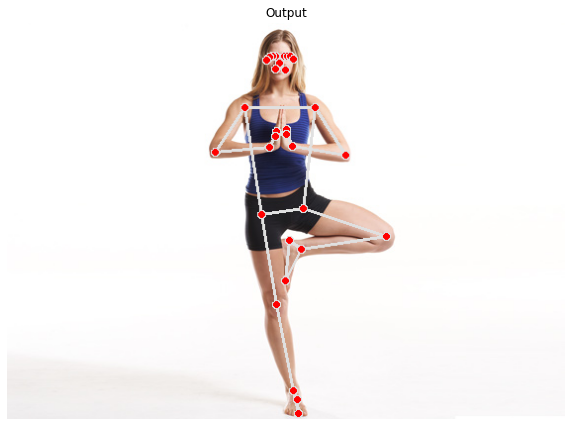

In [11]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

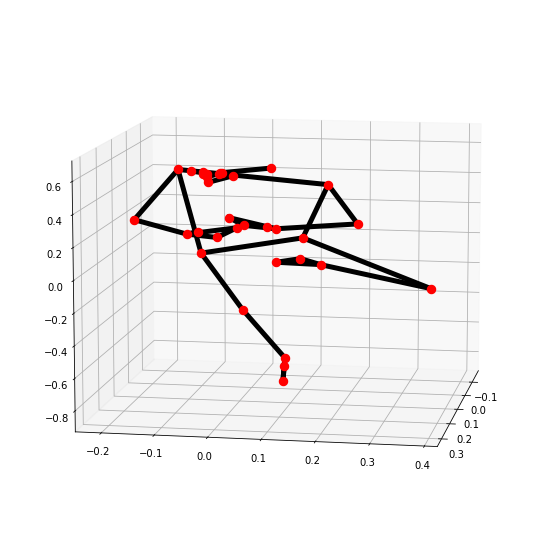

In [12]:
# Plot Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

# Create a Pose Detection Function
Now we will put all this together to create a function that will perform pose detection on an image and will visualize the results or return the results depending upon the passed arguments.

In [13]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

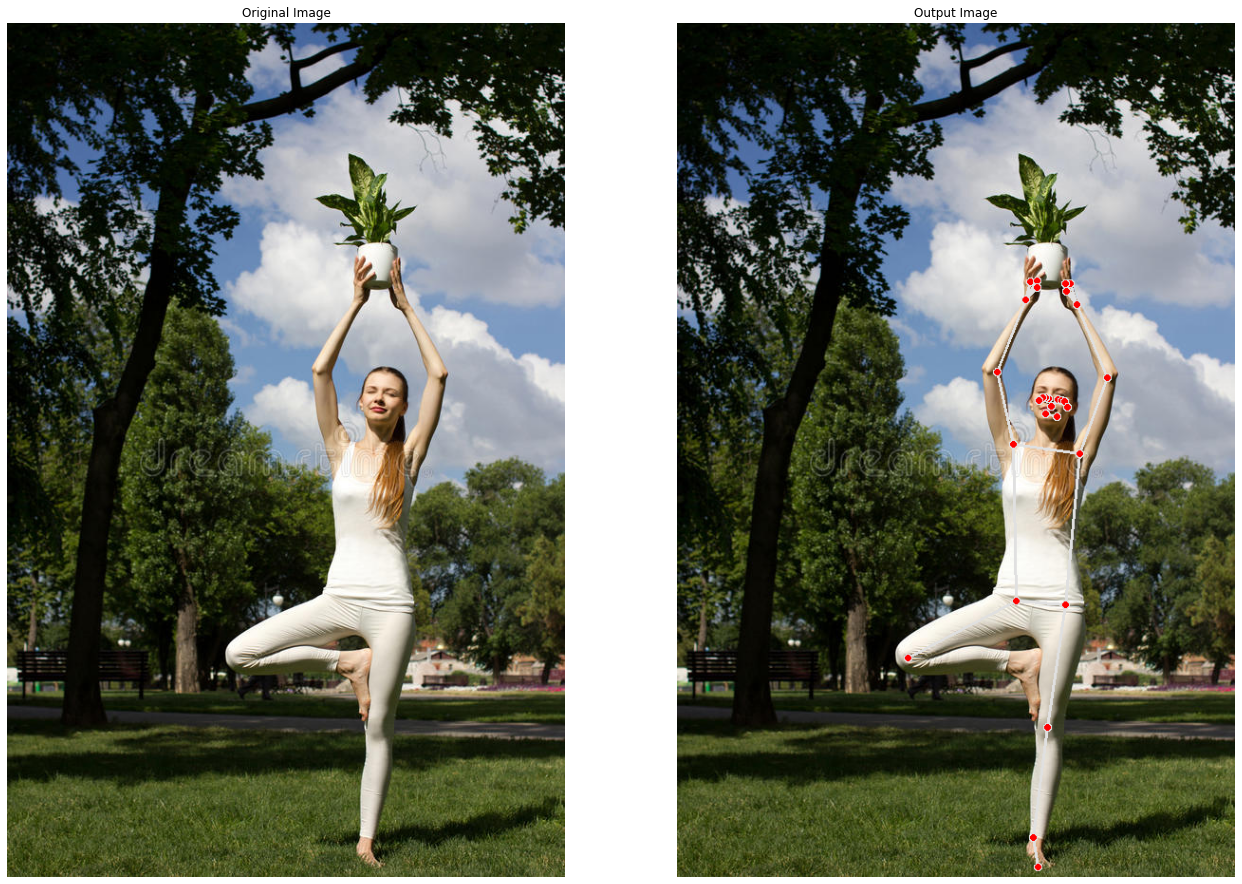

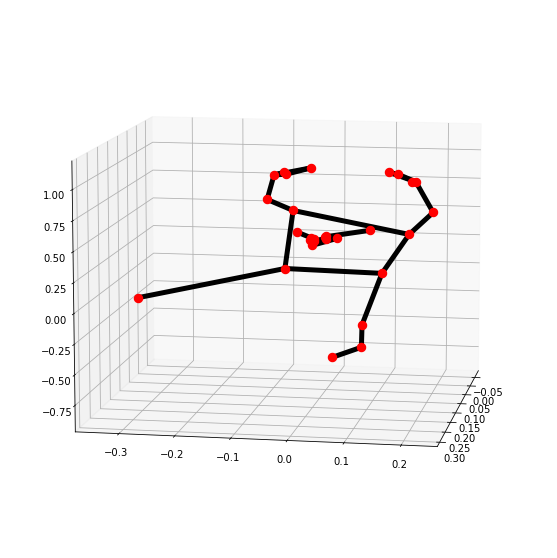

In [15]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('./DATASET/TRAIN/tree/00000198.jpg')
detectPose(image, pose, display=True)

# Pose Classification with Angle Heuristics
Create a Function to Calculate Angle between Landmarks

In [16]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360
    
    # Return the calculated angle.
    return angle

In [17]:
# Calculate the angle between the three landmarks.
angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


In [18]:
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

    '''
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the warrior II pose or the T pose.
    # As for both of them, both arms should be straight and shoulders should be at the specific angle.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:

        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:

    # Check if it is the warrior II pose.
    #----------------------------------------------------------------------------------------------------------------

            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

                # Check if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:

                    # Specify the label of the pose that is Warrior II pose.
                    label = 'Warrior II Pose' 
                        
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the T pose.
    #----------------------------------------------------------------------------------------------------------------
    
            # Check if both legs are straight
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:

                # Specify the label of the pose that is tree pose.
                label = 'T Pose'

    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:

            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'
                
   
    #----------------------------------------------------------------------------------------------------------------

    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label


Warrior II Pose
The Warrior II Pose (also known as Virabhadrasana II) is the same pose that the person is making in the image above. It can be classified using the following combination of body part angles:

Around 180° at both elbows
Around 90° angle at both shoulders
Around 180° angle at one knee
Around 90° angle at the other knee

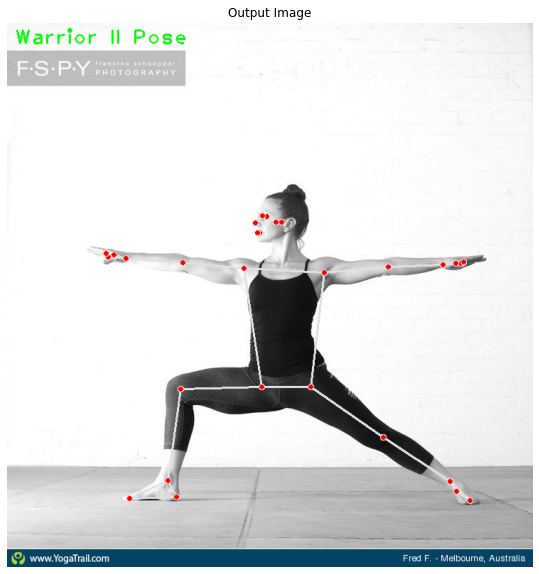

In [19]:
# Read a sample image and perform pose classification on it.
image = cv2.imread('./DATASET/TRAIN/warrior2/00000129.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

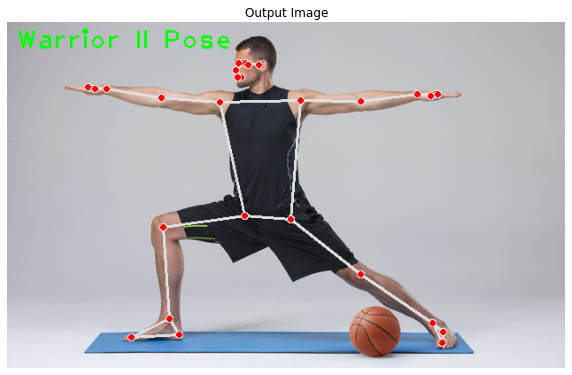

In [20]:
# Read another sample image and perform pose classification on it.
image = cv2.imread('./DATASET/TRAIN/warrior2/00000187.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

Tree Pose
Around 180° angle at one knee
Around 35° (if right knee) or 335° (if left knee) angle at the other knee

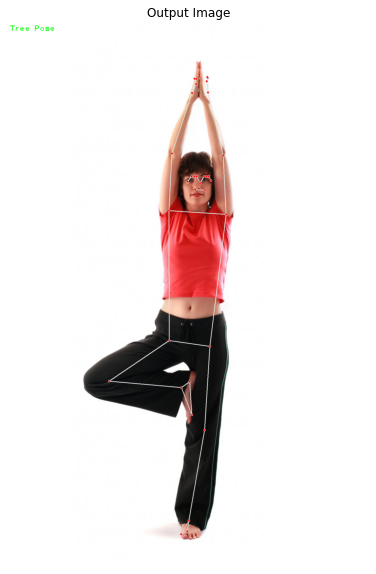

In [21]:
# Read a sample image and perform pose classification on it.
image = cv2.imread('./DATASET/TRAIN/tree/File15.jpg')
output_image, landmarks = detectPose(image, mp_pose.Pose(static_image_mode=True,
                                         min_detection_confidence=0.5, model_complexity=0), display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

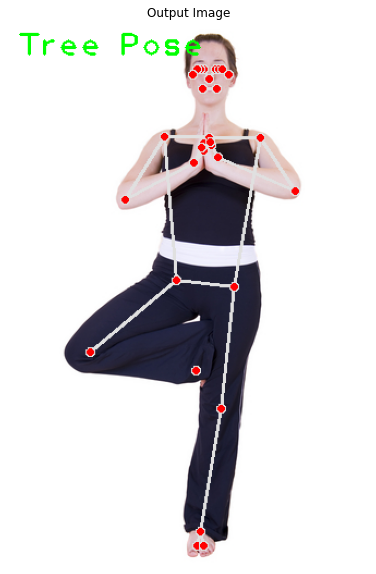

In [22]:
# Read another sample image and perform pose classification on it.
image = cv2.imread('./DATASET/TRAIN/tree/File18.jpg')
output_image, landmarks = detectPose(image, mp_pose.Pose(static_image_mode=True,
                                         min_detection_confidence=0.5, model_complexity=0), display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

In [ ]:
# Read another sample image and perform pose classification on it.
image = cv2.imread('./DATASET/TRAIN/tree/00000141.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

Pose Classification On Video


In [ ]:
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture('VIDEOS/y2.mp4')
#camera_video.set(3,1280)
#camera_video.set(4,960)


# Initialize a resizable window.
#cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)


# Iterate until the webcam is accessed successfully.

while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    #frame = cv2.flip(frame, 1)
   

    # Perform Pose landmark detection.
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    # Check if the landmarks are detected.
    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    # Display the frame.
    cv2.imshow('Pose Classification', frame)
    
    # Wait until a key is pressed.
  # Retreive the ASCII code of the key pressed
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()






In [ ]:

#Pose Classification On camweb
'''
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Initialize a resizable window.
cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    # Check if the landmarks are detected.
    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    # Display the frame.
    cv2.imshow('Pose Classification', frame)
    
    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()
'''

In [ ]:
Pose Detection calssfication

In [3]:
import mediapipe as mp
import cv2
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
import mediapipe as mp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
import tensorflow as tf
import os
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from google.colab.patches import cv2_imshow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Build the dataset using landmarks detection and save it as csv
def build_dataset(path, dataset_type):
        # path: ROOT PATH TO DATASET
        # dataset_type: type of dataset
        data = []
        for p in points:
                x = str(p)[13:]
                data.append(x + "_x")
                data.append(x + "_y")
                data.append(x + "_z")
                data.append(x + "_vis")
        data.append("target")  # name of the position
        data = pd.DataFrame(columns=data)  # Empty dataset
        count = 0

        dirnames = [x[1] for x in os.walk(path)][0]
        # walking through the whole training dataset
        for k in range(len(dirnames)):
                for img in os.listdir(path + "/" + dirnames[k]):
                        temp = []
                        img = cv2.imread(path + "/" + dirnames[k] + "/" +img)
                        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        results = pose.process(imgRGB)

                        if results.pose_landmarks:
                                landmarks = results.pose_landmarks.landmark

                                for i, j in zip(points, landmarks):

                                        temp = temp + [j.x, j.y, j.z, j.visibility]

                                temp.append(dirnames[k]) #adding pos_name to dataframe

                                data.loc[count] = temp
                                count +=1
        data.to_csv(dataset_type+".csv") # save the data_train as a csv file | viewing on ExcelReader might suck


In [6]:
# Predict the name of the poses in the image
def predict(img, model, show=False):
        temp = []
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = pose.process(img)

        if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                for j in landmarks:
                        temp = temp + [j.x, j.y, j.z, j.visibility]
                y = model.predict([temp])

                if show:
                        mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
                        cv2.putText(img, str(y[0]), (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),3)
                        cv2_imshow(img) #cv2.imshow("Video", img)
                        cv2.waitKey(0)

In [7]:
def predict_video(model, video="0", show=False):
        cap = cv2.VideoCapture(video)
        while cap.isOpened():
                temp = []
                success, img = cap.read()
                if not success:
                        print("Ignoring empty camera frame.")
                        continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = pose.process(img)
                if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        for j in landmarks:
                                temp = temp + [j.x, j.y, j.z, j.visibility]
                        y = model.predict([temp])
                        name = str(y[0])
                        if show:
                                mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
                                (w, h), _ = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)
                                cv2.rectangle(img, (40, 40), (40+w, 60), (255, 255, 255), cv2.FILLED)
                                cv2.putText(img, name, (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
                                cv2_imshow(img) #cv2.imshow("Video", img)
                                if cv2.waitKey(5) & 0xFF == 27:
                                        break
        cap.release()

In [8]:
# Use this to evaluate any dataset you've built
def evaluate(data_test, model, show=False):
        target = data_test.loc[:, "target"]  # list of labels
        target = target.values.tolist()
        predictions = []
        for i in range(len(data_test)):
                tmp = data_test.iloc[i, 0:len(data_test.columns) - 1]
                tmp = tmp.values.tolist()
                predictions.append(model.predict([tmp])[0])
        if show:
                print(confusion_matrix(predictions, target), '\n')
                print(classification_report(predictions, target))
        return predictions

In [9]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils  # For drawing keypoints
points = mpPose.PoseLandmark  # Landmarks
build_dataset("/content/drive/My Drive/DATASET/TRAIN", "train")
build_dataset("/content/drive/My Drive/DATASET/TEST", "test")

In [10]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [11]:
data_train = data_train.drop(labels="Unnamed: 0", axis=1)  # delete if error about it
X, Y = data_train.iloc[:, :data_train.shape[1] - 1], data_train['target']

In [12]:
from sklearn.svm import SVC

data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_train = data_train.drop(labels="Unnamed: 0", axis=1)  # delete if error about it
X, Y = data_train.iloc[:, :data_train.shape[1] - 1], data_train['target']
model = SVC(kernel='poly', decision_function_shape='ovo')
model.fit(X, Y)
mpPose = mp.solutions.pose
pose = mpPose.Pose(static_image_mode=True, min_detection_confidence=0.2)
mpDraw = mp.solutions.drawing_utils

# Test phase : build test dataset then evaluate
data_test.drop(labels="Unnamed: 0", axis=1, inplace=True)  # delete if error about it
predictions = evaluate(data_test, model, show=True)
# I think downdog and plank get these results because of the absence of variations in the hands positions
# Unlike tree and goddess which present some hand position variations

#predict_video(model, "vid1.mp4", show=True)
#predict_video(model, "vid2.mp4", show=True)
#cv2.destroyAllWindows()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

[[81  0  5  0  1]
 [ 0 53  3  6  5]
 [ 6  2 92  1  2]
 [ 0  8  0 53  4]
 [ 0 13  0  3 90]] 

              precision    recall  f1-score   support

     downdog       0.93      0.93      0.93        87
     goddess       0.70      0.79      0.74        67
       plank       0.92      0.89      0.91       103
        tree       0.84      0.82      0.83        65
    warrior2       0.88      0.85      0.87       106

    accuracy                           0.86       428
   macro avg       0.85      0.86      0.85       428
weighted avg       0.87      0.86      0.86       428



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa